In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

import sys
sys.path.append('C:/Users/acomi/DESU_OFF/scripts')

In [36]:
path= "C:/Users/acomi/Downloads/data_DESU_2.csv"
df = pd.read_csv(path, delimiter=';', decimal = ",", encoding="utf-8", na_values=["", " "], na_filter=True)
df.head()

,mouse,vol(fv),perfctx,perfthal,Ace,Ala,Asp,bGlu,GABA,Gly,...,Lac,Myo,Scy,Suc,Tau,tCo,tNa,Glx,tCr,behav
0,C1-2R,0.058380,44.14,69.0910,1.734060e-17,7.599709e-02,8.982798e-02,0.101835,0.080081,0.123462,...,0.071801,2.445724e-01,1.497486e-02,0.016576,0.177655,0.079899,0.095911,0.360444,0.414571,9.56
1,C1-4V,0.054904,119.74,173.4525,2.864256e-02,2.074650e-17,2.074650e-17,0.149997,0.199037,0.072974,...,0.083009,1.058961e-01,1.032199e-02,0.031450,0.127429,0.073409,0.103809,0.251717,0.245582,11.96
2,C3-1N,0.054323,117.88,110.9430,2.053260e-17,2.485268e-02,2.053260e-17,0.030867,0.108392,0.174835,...,0.057157,1.831715e-01,2.431678e-02,0.027117,0.199119,0.043085,0.098994,0.300538,0.301312,4.32
3,C3-3N,0.057803,49.63,65.0625,3.084990e-17,1.393090e-02,5.419405e-02,0.262064,0.072793,0.150699,...,0.133484,3.325312e-01,3.084990e-17,0.017590,0.463181,0.112738,0.401151,0.443224,0.741725,196.04
4,C3-4N,0.052949,NaN,NaN,1.288696e-02,5.345350e-02,1.113894e-01,0.145943,0.006817,0.161985,...,0.117177,2.658580e-17,2.981603e-02,0.103459,0.270617,0.080647,0.248493,0.514835,0.572566,129.68


In [37]:
df = df.drop(['mouse'], axis = 1)

## Exploring the dataset

### Visualization of the data and outliers

In [41]:
#We remove outliers in the selected columns

cols_to_clean = ["vol(fv)", "perfctx", "Ace", "Ala", "bGlu", "Gly", "Tau", "tCo", "Glx"]

work_df = df.copy()

for col in cols_to_clean:
    Q1 = work_df[col].quantile(0.25)
    Q3 = work_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Replace outliers with NaN 
    work_df.loc[(work_df[col] < lower_bound) | (work_df[col] > upper_bound), col] = np.nan


### Tranches of behavior and encoding (for classifier)

In [43]:
from sklearn.preprocessing import LabelEncoder

# we create 3 tranches (low, medium, high) using quantiles
work_df["behav_category"] = pd.qcut(work_df["behav"],q=3,labels=["low", "medium", "high"])

# Encode categories into numeric values
le = LabelEncoder()
work_df["behav_encoded"] = le.fit_transform(work_df["behav_category"])
print("\nEncoded column:")
print(work_df[["behav", "behav_category", "behav_encoded"]].head())


Encoded column:
    behav behav_category  behav_encoded
0    9.56            low              1
1   11.96         medium              2
2    4.32            low              1
3  196.04           high              0
4  129.68           high              0


C:\Users\acomi\AppData\Local\Temp\ipykernel_10196\975080314.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = work_df.groupby("behav_category")["behav"].agg(["count", "mean", "std"]).reset_index()
C:\Users\acomi\AppData\Local\Temp\ipykernel_10196\975080314.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="behav_category", y="mean", data=summary, errorbar="sd", capsize=0.2, palette="Set2")


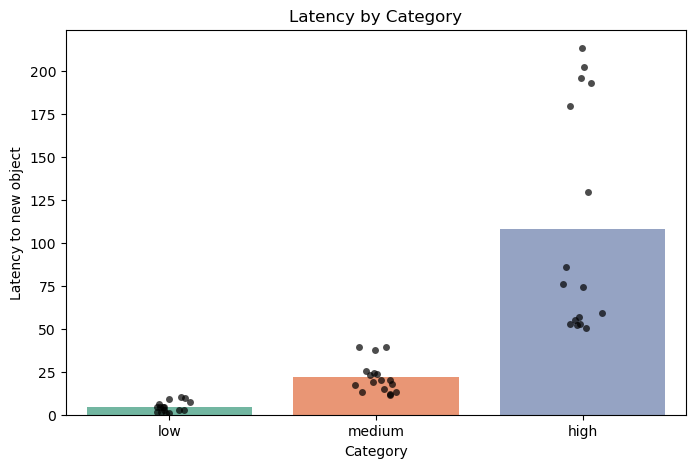

In [44]:
# check of how the data is distributed by category
summary = work_df.groupby("behav_category")["behav"].agg(["count", "mean", "std"]).reset_index()

plt.figure(figsize=(8,5))
sns.barplot(x="behav_category", y="mean", data=summary, errorbar="sd", capsize=0.2, palette="Set2")
sns.stripplot(x="behav_category", y="behav", data=work_df, color="black", size=5, jitter=True, alpha=0.7)
plt.ylabel("Latency to new object")
plt.xlabel("Category")
plt.title("Latency by Category")
plt.show()



In [45]:
work_df = work_df.drop(['behav', 'behav_category'], axis = 1)

### ML Pipeline

In [47]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cross_decomposition import PLSRegression
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import LeaveOneOut, GridSearchCV, learning_curve
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from collections import Counter
from pls_fselector import PLSFeatureSelector 
from learning_curve import plot_learning_curve
from shap_regr import plot_shap_summary

X = work_df.drop(columns=["behav_encoded"]).values
y = work_df["behav_encoded"].values
feature_names = work_df.drop(columns=["behav_encoded"]).columns

loo = LeaveOneOut()

#### Logistic regression

c:\Users\acomi\anaconda3\envs\formation\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\acomi\anaconda3\envs\formation\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\acomi\anaconda3\envs\formation\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\acomi\anaconda3\envs\formation\Lib\site-packages\sklearn\linear_model\_logistic.py

Best Logistic Regression params (LOO-CV): {'logistic__C': np.float64(0.1), 'logistic__penalty': 'l2'}


c:\Users\acomi\anaconda3\envs\formation\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\acomi\anaconda3\envs\formation\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\acomi\anaconda3\envs\formation\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\acomi\anaconda3\envs\formation\Lib\site-packages\sklearn\linear_model\_logistic.py

LOO-CV Logistic Regression+PLS: Accuracy=0.408

Classification report:
               precision    recall  f1-score   support

           0       0.50      0.50      0.50        16
           1       0.38      0.31      0.34        16
           2       0.35      0.41      0.38        17

    accuracy                           0.41        49
   macro avg       0.41      0.41      0.41        49
weighted avg       0.41      0.41      0.41        49


Feature selection stability aka each feature was chosen:
vol(fv): 49/49 times
bGlu: 49/49 times
tNa: 49/49 times
perfthal: 43/49 times
Gly: 42/49 times
Myo: 41/49 times
Gsh: 6/49 times
Lac: 5/49 times
Ala: 4/49 times
Scy: 2/49 times
Ace: 2/49 times
Asp: 1/49 times
Suc: 1/49 times


c:\Users\acomi\anaconda3\envs\formation\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\acomi\anaconda3\envs\formation\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\acomi\anaconda3\envs\formation\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\acomi\anaconda3\envs\formation\Lib\site-packages\sklearn\linear_model\_logistic.py

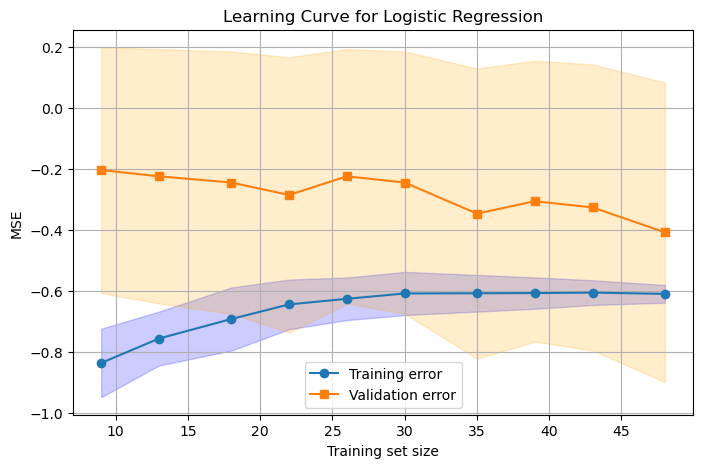

c:\Users\acomi\anaconda3\envs\formation\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


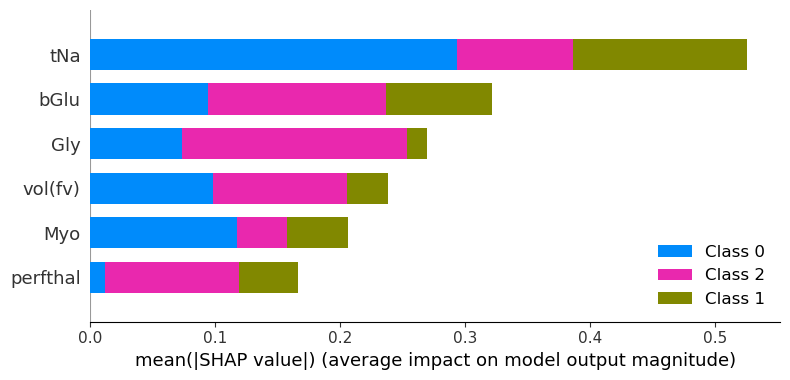

In [48]:
from sklearn.linear_model import LogisticRegression


# Pipeline: Imputer + Scaler + PLS + Model

pipe = Pipeline([
    ("imputer", KNNImputer(n_neighbors=3)),
    ("scaler", RobustScaler()),
    ("pls_select", PLSFeatureSelector(n_components=2, n_features=6, feature_names=feature_names)),
    ("logistic", LogisticRegression(max_iter=5000, solver="liblinear", multi_class="auto"))
])


# Hyperparameter grid
param_grid = {
    "logistic__C": np.logspace(-3, 3, 10),
    "logistic__penalty": ["l1", "l2"]
}
grid = GridSearchCV(pipe, param_grid, cv=loo, scoring="accuracy")
grid.fit(X, y)
best_params = grid.best_params_
print("Best Logistic Regression params (LOO-CV):", best_params)

logreg_params = {k.replace("logistic__", ""): v for k, v in best_params.items()}

# Evaluate with LOO-CV and chosen best hyperparameters
pipe_best = Pipeline([
    ("imputer", KNNImputer(n_neighbors=3)),
    ("scaler", RobustScaler()),
    ("pls_select", PLSFeatureSelector(n_components=2, n_features=6, feature_names=feature_names)),
    ("logistic", LogisticRegression(**logreg_params, max_iter=5000, solver="liblinear", multi_class="auto"))
])

y_pred = np.zeros_like(y)
selected_features_all = []

for train_idx, test_idx in loo.split(X):
    pipe_best.fit(X[train_idx], y[train_idx])
    y_pred[test_idx] = pipe_best.predict(X[test_idx])
    selected_features_all.extend(pipe_best.named_steps["pls_select"].get_feature_names())

acc = accuracy_score(y, y_pred)
print(f"LOO-CV Logistic Regression+PLS: Accuracy={acc:.3f}")
print("\nClassification report:\n", classification_report(y, y_pred))

# Feature selection stability
feature_counts = Counter(selected_features_all)
print("\nFeature selection stability aka each feature was chosen:")
for feat, count in feature_counts.most_common():
    print(f"{feat}: {count}/{len(y)} times")

#Plotting of the learning curve
plot_learning_curve(pipe_best, X, y, cv=loo, scoring="accuracy", title="Learning Curve for Logistic Regression")

#Shap to visually explain the model
plot_shap_summary(pipe_best, X, y, feature_step="pls_select", model_step="logistic")





#### SGDC classifier with elastic net penalty

Best SGDC params: {'sgdc__alpha': np.float64(0.000774263682681127), 'sgdc__l1_ratio': 0.1}
LOO-CV Elastic Net + PLS: Accuracy=0.510

Classification report:
               precision    recall  f1-score   support

           0       0.50      0.44      0.47        16
           1       0.47      0.44      0.45        16
           2       0.55      0.65      0.59        17

    accuracy                           0.51        49
   macro avg       0.51      0.51      0.50        49
weighted avg       0.51      0.51      0.51        49


Feature selection stability aka each feature was chosen:
vol(fv): 49/49 times
bGlu: 49/49 times
tNa: 49/49 times
perfthal: 43/49 times
Gly: 42/49 times
Myo: 41/49 times
Gsh: 6/49 times
Lac: 5/49 times
Ala: 4/49 times
Scy: 2/49 times
Ace: 2/49 times
Asp: 1/49 times
Suc: 1/49 times


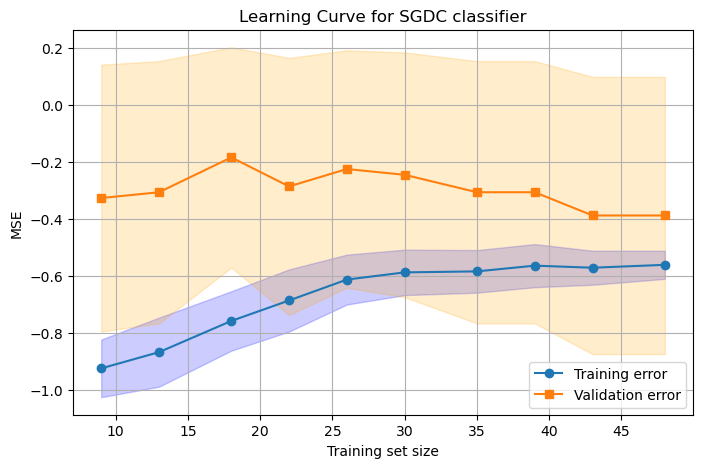

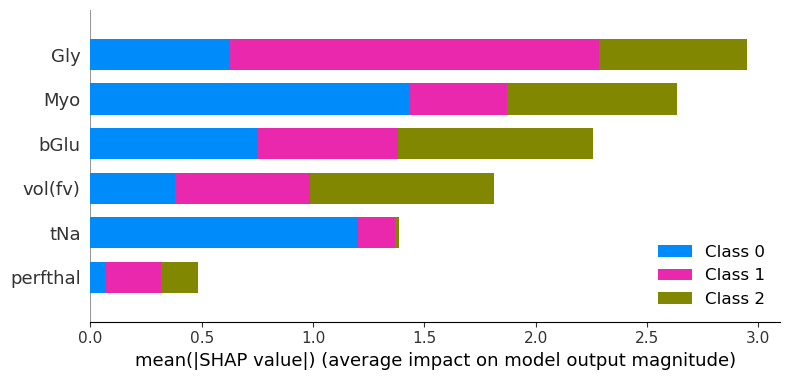

In [ ]:
from sklearn.linear_model import SGDClassifier

# Pipeline: Imputer + Scaler + PLS + SGDC classifier
# -----------------------
pipe = Pipeline([
    ("imputer", KNNImputer(n_neighbors=3)),
    ("scaler", RobustScaler()),
    ("pls_select", PLSFeatureSelector(n_components=2, n_features=6, feature_names=feature_names)),
    ("sgdc", SGDClassifier(loss="log_loss", penalty="elasticnet", max_iter=5000, random_state=42))])


# Hyperparameter grid
param_grid = {"sgdc__alpha": np.logspace(-4, 0, 10),  # regularization strength
    "sgdc__l1_ratio": [0.1, 0.5, 0.7, 0.9, 1.0]}  # 1.0 = L1 (lasso), 0 = L2 (ridge) 

grid = GridSearchCV(pipe, param_grid, cv=loo, scoring="accuracy")
grid.fit(X, y)
best_params = grid.best_params_
print("Best SGDC params:", best_params)
best_alpha = best_params["sgdc__alpha"]
best_l1_ratio = best_params["sgdc__l1_ratio"]


# Evaluate with LOO-CV
pipe_best = Pipeline([
    ("imputer", KNNImputer(n_neighbors=3)),
    ("scaler", RobustScaler()),
    ("pls_select", PLSFeatureSelector(n_components=2, n_features=6, feature_names=feature_names)),
    ("sgdc", SGDClassifier(loss="log_loss", penalty="elasticnet", alpha=best_alpha, l1_ratio=best_l1_ratio, max_iter=5000, random_state=42))])

y_pred = np.zeros_like(y)
selected_features_all = []

for train_idx, test_idx in loo.split(X):
    pipe_best.fit(X[train_idx], y[train_idx])
    y_pred[test_idx] = pipe_best.predict(X[test_idx])
    selected_features_all.extend(pipe_best.named_steps["pls_select"].get_feature_names())

acc = accuracy_score(y, y_pred)
print(f"LOO-CV SGDC + PLS: Accuracy={acc:.3f}")
print("\nClassification report:\n", classification_report(y, y_pred))

# Feature selection stability
feature_counts = Counter(selected_features_all)
print("\nFeature selection stability aka each feature was chosen:")
for feat, count in feature_counts.most_common():
    print(f"{feat}: {count}/{len(y)} times")

#Plotting of the learning curve
plot_learning_curve(pipe_best, X, y, cv=loo, scoring="accuracy", title="Learning Curve for SGDC classifier")

#Shap to visually explain the model
plot_shap_summary(pipe_best, X, y, feature_step="pls_select", model_step="sgdc")
